This notebook contains investment related analysis for Lending Club's loan originated during the calendar year of 2015. The goal(s) are to understand the costs of defaulted loans vs the gains from paid off loans, as well as identifying differences between customers who default on their loans vs. those that pay their loans off in order to identify potential additional features for machine learning. For ease of consumption I've summarized the high level findings at the top of the notebook, said findings are repeated below with the relevant code blocks. 

Follow these steps to use this notebook:

1) Download the 2015 calendar year data from Lendingclub.com 
2) Run the LC_preprocessing_final.py by pointing it to the right csv file and just running the entire script. The script will produce an output CSV. 
3) Import the file created by the above and then run the entire LC_cleaning_lightEDA notebook to do another round of data cleaning, measure creation and handling issues of missing values 
4) Import the CSV output of the above to this notebook and just follow the path below. 

While EDA didn't per se identify a strong predictor of potential loan defaults, it did identify some general trends that could at the very least better inform investment decisions and ideally were strong "enough" to be the basis of a useful machine learning model. 

* The entire cohort of loans would deliver a return of around 1.91% for a composite loan term of 40 months. 
* Bad loans are very expensive relative to benefit of paid off loans. On average a single bad loan would wipe out the gains from 2.6 paid off loans. As a result, a machine learning model that identifies a very high % of the bad loans, but has a large number of false negatives is still "good" from an investor's perspective because a single individual can't invest in all of the loans, so minimizing their exposure to the bad loans is the top priority. 
* The default rate is 19.2% for all of the loans 
* Grade A loans have a significantly lower default rate than all other categories (5.54% vs. 12.25% for Grade B, 20% for C and growing to as high as 51%), however investing in a representative pool of loans of grades A, B & C would yield slightly higher returns 2.3% vs. 2.2%. 
* Grades D, E, F, G have default rates ranging from 30% to 51.2% and constitutes 67% of all bad loans 
* Most loans have a grade of C, B or A making up 28.4%, 28.2% and 17.9% of all respectively. 
* The default and paid off loan cohorts are remarkably similar, with differences across debt to income ratios, credit scores, delinquency rates on other accounts and the like rarely differing by more than 10% and in many cases less than 5%. The areas with the largest differrences were average interest rate ~25% and a roughly $7k/year difference in income. 
* Despite the trend isolating grade A, B & C, high income and low interest loans still produced relatively small annualized returns of ~2.4% , higher than investing in a broad index of the loans, but still relatively anemic. 
* There was a generally postive and linear relationship between interest rates and default rates
* Higher incomes tended to indicate lower default rates 
* Defaulted loans were nearly twice as likely to be of the 60 month time frame vs. paid off loans 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# set size parameters for the plots 

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 


# set view parameters for the data frames 


pd.set_option('max_columns', None)
pd.set_option('display.max_rows', None)

In [25]:
data = pd.read_csv('data/LC_2015_clean(4).csv')

data.shape

(368014, 71)

In [4]:
data.head(5)

,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,tot_cur_bal,total_bal_ex_mort,emp_length_months,dti_dec,length_of_credit_history,monthly_income,monthly_debt_payments,updated_monthly_debt_payments,lost_principle,total_payments,post_loan_dti,net_gain,log_monthly_income,log_revol_bal,log_monthly_debt_payments,log_updated_monthly_debt_payments,log_total_debt,log_total_debt_excluding_mortgage,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq
0,20000.0,36 months,0.1485,691.84,C,6,RENT,110000.0,Not Verified,2015-12-01,Fully Paid,credit_card,IL,12.45,0.0,2007-06-01,690.0,0.0,0.0,8.0,0.0,0.0,21374.0,0.845,12.0,24889.01336,24889.01,20000.00,4889.01,0.0,0.0,Individual,0.0,0.0,3.0,5356.0,0.0,102.0,16.0,10.0,0.0,9.0,0.0,0.0,1.0,0.0,100.0,0.0,37491.0,37491.0,72,0.1245,102,9166.666667,1141.250000,1833.090000,0.00,35.975100,0.199973,4889.01,9.123329,9.969931,7.039879,7.513758,10.531856,10.531856,1,0,0,0.0,0.0
1,20000.0,36 months,0.1577,700.88,D,5,RENT,70000.0,Not Verified,2015-12-01,Fully Paid,house,FL,22.21,0.0,2004-07-01,680.0,0.0,38.0,24.0,0.0,0.0,19077.0,0.366,63.0,21780.58678,21780.59,20000.00,1780.59,0.0,0.0,Individual,0.0,0.0,9.0,2759.0,0.0,137.0,2.0,2.0,1.0,9.0,0.0,5.0,39.0,0.0,92.1,264.0,63456.0,63456.0,60,0.2221,137,5833.333333,1295.583333,1996.463333,0.00,31.076057,0.342251,1780.59,8.671344,9.856239,7.166716,7.599133,11.058102,11.058102,0,1,0,-46.0,0.0
2,10000.0,60 months,0.1797,253.78,D,2,MORTGAGE,55000.0,Not Verified,2015-12-01,Charged Off,credit_card,CO,35.70,0.0,2001-04-01,685.0,0.0,0.0,14.0,0.0,0.0,38623.0,0.780,28.0,5558.20000,5558.20,2687.15,2871.05,0.0,0.0,Individual,0.0,0.0,4.0,20578.0,0.0,176.0,7.0,6.0,6.0,6.0,0.0,0.0,6.0,0.0,100.0,0.0,288087.0,71518.0,24,0.3570,176,4583.333333,1636.250000,1890.030000,7312.85,21.901647,0.412370,-4441.80,8.430182,10.561603,7.400162,7.544348,12.571018,11.177704,1,0,0,0.0,0.0
3,20000.0,36 months,0.0849,631.26,B,10,MORTGAGE,85000.0,Not Verified,2015-12-01,Fully Paid,major_purchase,SC,17.61,1.0,1999-02-01,705.0,0.0,3.0,8.0,0.0,0.0,826.0,0.057,15.0,21538.50898,21538.51,20000.00,1538.51,0.0,0.0,Individual,0.0,0.0,4.0,17700.0,0.0,55.0,32.0,13.0,3.0,8.0,0.0,1.0,9.0,0.0,93.3,0.0,141601.0,27937.0,120,0.1761,201,7083.333333,1247.375000,1878.635000,0.00,34.119870,0.265219,1538.51,8.865500,6.716595,7.128797,7.538301,11.860769,10.237707,0,1,0,-81.0,0.0
4,10000.0,36 months,0.0649,306.45,A,6,RENT,85000.0,Not Verified,2015-12-01,Fully Paid,credit_card,PA,13.07,0.0,2002-04-01,685.0,1.0,0.0,14.0,1.0,1.0,10464.0,0.345,23.0,10998.97157,10998.97,10000.00,998.97,0.0,0.0,Individual,0.0,0.0,7.0,1997.0,0.0,129.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,95.7,8341.0,27957.0,27957.0,72,0.1307,164,7083.333333,925.791667,1232.241667,0.00,35.891570,0.173964,998.97,8.865500,9.255696,6.830649,7.116590,10.238423,10.238423,1,0,0,0.0,0.0


In [75]:
# create empty data frame and empty list for tracking performance of various "slices" of the data 

performance_df = pd.DataFrame(columns=['avg_interest_rate',
                                       'avg_loan_amount',
                                       'avg_lost_principle',
                                       'avg_interest_received',
                                       'avg_gains($)',
                                       'avg_gains(%)',
                                       'avg_total_payments',
                                       'annualized_return'])

# create empty list to store index for the above

df_index = []

In order to make the notebook cleaner and more readable, the next couple of cells will define functions that will be used to expedite data analysis. 

In [6]:

# function to calculate high level investment performance from a # given data frame 
# If you pass a data frame that was prepared by the cleaning .py, followed by the light EDA 
# notebook it will do the rest # and return the high level stats in a list. 


def calc_performance(df):

    # this function calcualates high level data like average interest, 
    # loan size, net gains and annualized returns 
    
    output_list = []

    avg_interest_rate = 100 * df['int_rate'].mean()

    avg_loan_size = df['funded_amnt'].mean()

    avg_lost_principle = df['lost_principle'].mean()

    avg_rec_interest = df['total_rec_int'].mean()

    avg_gains = df['net_gain'].mean()

    avg_gains_per = 100 * (avg_gains/avg_loan_size)

    avg_total_payments = df['total_payments'].mean()

    gains_dec = avg_gains_per / 100

    # multiply total payments by 30 to get the approximate # of days
    days = avg_total_payments * 30

    # calculate annualized return
    annualized_return = (((1 + gains_dec) ** (365/days)) - 1) * 100

    # add calculations to output list

    output_list = [avg_interest_rate, avg_loan_size, avg_lost_principle,
                   avg_rec_interest, avg_gains, avg_gains_per,
                   avg_total_payments, annualized_return]

    
    return output_list


In [7]:
# defining function to add the list to a data frame 

def add_df(data, df):

    # convert list to series

    list_series = pd.Series(data, index=df.columns)

    df = df.append(list_series, ignore_index=True)

    df = df.round(3)

    return df



In [8]:
# function that updates the index of a data frame 

def update_index(add_list, df): 
    
    # update existing index list with new elements, requires passing a list of values for
    # the index, as well as 
    
    df_index.extend(add_list)
    
    # update performance data frame index 
    
    df = df.index = df_index 
    
    return performance_df 


In [9]:
# function that inserts a column into a data frame 

def add_column(col_list, data, position, title):
    
    data.insert(position, title, col_list, True)
    
    return data 



In [10]:
# function that will append two data frames together 

def append_df(df1, df2):
        
    df1 = df1.append(df2, ignore_index=True)
        
    return df1 


In [11]:
# function that will create two side by side violin plots showing the distribution of a 
# variable on the Y axis vs a categorical variable on the x axis. 
# this function is used by passing a data frame, plus the column label for the x and y axis. 

def violin_plot(x, y, data, title):
    
    ax = sns.violinplot(x=x, y=y, inner='quartile', data=data)
    ax.set_title(title, fontsize=16)
    
    return ax 
    

In [12]:
# data frame for counting # of items of a particular category e.g. % defaults vs. paid off
# for loans 

def categorical_count(data, category):
    
    # generate a new df with a count of each category
    
    cat_count = pd.DataFrame(data[category].value_counts())
    
    # reset index and fix column labels 
    
    cat_count = cat_count.reset_index()

    cat_count.rename(columns={category:'count'}, inplace = True)
    cat_count.rename(columns={'index':category}, inplace = True)
    
 
    
    # calculate # of items so we can calculate % of total 
    
    total_items = len(data)
    
    
    # add % of total 
    
    cat_count['per_of_total'] = cat_count['count'] / total_items
    

    return cat_count





In [13]:
# this function will put a range of values into bins,
# useful for doing things like comparing an outcome (like loan status) 
# vs an income or interest rate range 
# the input variables are data = the data frame, freq = intervals the vales 
# sliced by. Value is the column in the data frame we're putting into bins 


def make_bins(data, freq, value):


    # get minimum and maximum values

    lowest = data[value].min()
    highest = data[value].max()


    # create bins 
    bins = pd.interval_range(start=lowest, freq=freq, end=highest, closed='left')

    bin_column = value + '_bin'
    
    
    data[bin_column] = pd.cut(data[value], bins=bins)


    # group by bins and use .mean() to get the default rate for each 

    
    
    bin_df = data.groupby(bin_column).mean()

    # there won't be values or all of the bins 

    bin_df = bin_df.round(3)
    
    
    return bin_df

    



In [14]:
# this function will generate line plots 

def line_plot(data, x, y, title):
    
    sns.lineplot(data=data, x=x, y=y)
    plt.title(title)



In [39]:
def default_by_category(data, category):
    
    data = pd.get_dummies(data, columns = ['loan_status'])

    # update the column names 
    data.rename(columns={'loan_status_Charged Off':'default'}, inplace = True)
    data.rename(columns={'loan_status_Fully Paid':'paid'}, inplace = True)
    
    #group by category 
    data = data.groupby(category).mean()
    
    return data 





Now the functions are loaded, we can now start analyzing data. We'll start by doing the following:
* Splitting out data frames with just paid off loans and then defaulted loans 
* calculating high level stats for the dataset overall and then for the defaulted and paid off loans 


In [17]:
# split out two separate datasets for paid vs. defaulted loans 

default_df = data[(data['loan_status'] == 'Charged Off')]

paid_df = data[(data['loan_status'] == 'Fully Paid')]



In [18]:
# calculate the default rate for the overall data set

default = categorical_count(data, 'loan_status')

default.head()

,loan_status,count,per_of_total
0,Fully Paid,297465,0.808298
1,Charged Off,70549,0.191702


In [29]:
# high level summary stats 

data.describe()

,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,tot_cur_bal,total_bal_ex_mort,emp_length_months,dti_dec,length_of_credit_history,monthly_income,monthly_debt_payments,updated_monthly_debt_payments,lost_principle,total_payments,post_loan_dti,net_gain,log_monthly_income,log_revol_bal,log_monthly_debt_payments,log_updated_monthly_debt_payments,log_total_debt,log_total_debt_excluding_mortgage,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq
count,368014.000000,368014.000000,368014.000000,368014.000000,3.680140e+05,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,3.680140e+05,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,3.680140e+05,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,3.680140e+05,3.680140e+05,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000,368014.000000
mean,15305.119370,0.125280,445.644821,6.104906,7.840314e+04,19.010590,0.349117,693.688107,0.573177,17.552202,12.013138,0.229171,0.130250,1.769716e+04,0.537860,25.542050,16506.152754,16499.683987,13233.151110,2971.978869,2.032390e+00,0.020505,0.004766,0.010337,4.702413,13265.357568,12.453706,181.776438,13.403227,7.947494,1.671138,6.025904,12.891662,0.525937,8.792513,0.000636,93.917810,256.210337,1.422539e+05,5.317235e+04,73.258876,0.190106,196.080315,6533.595367,1144.934916,1590.579737,2071.968261,36.801537,0.268406,900.010609,8.632799,9.308228,6.836096,7.229387,11.257093,10.542160,0.836042,0.100730,0.063229,-25.831006,-17.374806
std,8586.298618,0.043291,246.982593,3.577101,7.627836e+04,8.641085,0.930889,30.072439,0.868934,23.176980,5.644580,0.645904,0.382216,2.412136e+04,0.238843,12.108771,10744.463960,10740.239881,8861.151737,3010.586757,1.409677e+01,0.158620,0.076818,0.116499,3.211659,15773.064515,742.089428,90.161295,16.956084,8.973611,1.985530,5.951528,21.879397,1.335433,7.520354,0.027576,8.889624,2262.513193,1.563262e+05,4.926746e+04,42.925206,0.086411,86.127610,6356.529904,743.915125,874.374440,5315.297950,12.148966,0.103861,5793.959021,0.522760,1.120019,0.695818,0.549622,1.216693,0.887262,0.370238,0.300971,0.243374,29.553879,26.825433
min,1000.000000,0.053200,14.010000,1.000000,3.800000e+03,0.000000,0.000000,660.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,-5.100000e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,12.000000,0.000000,36.000000,316.666667,0.000000,31.420000,0.000000,0.000000,0.000623,-35000.000000,5.757850,0.000000,-0.941609,3.447445,0.000000,0.000000,0.000000,0.000000,0.000000,-83.000000,-83.000000
25%,8750.000000,0.091700,265.840000,2.000000,4.800000e+04,12.500000,0.000000,670.000000,0.000000,0.000000,8.000000,0.000000,0.000000,6.506000e+03,0.360000,17.000000,8128.909815,8126.917500,6000.000000,987.252500,0.000000e+00,0.000000,0.000000,0.000000,2.000000,3276.000000,0


LC assigns grades to their loans in order to help investors assess the risk with a particular loan, how do those grades match up with credit measures, financial status and default rates? 

In [74]:


grade_analysis = data[['int_rate', 'loan_status', 'fico_range_low','grade', 
                       'monthly_debt_payments', 
                       'countdown_zero_delinq','annual_inc',
                       'monthly_income', 'dti_dec', 'post_loan_dti']]


grade_performance = pd.get_dummies(grade_analysis, columns = ['loan_status'])

# update the column names 
grade_performance.rename(columns={'loan_status_Charged Off':'default'}, inplace = True)
grade_performance.rename(columns={'loan_status_Fully Paid':'paid'}, inplace = True)


grade_performance = grade_performance.groupby('grade').mean()


grade_performance.head(10)


,int_rate,fico_range_low,monthly_debt_payments,countdown_zero_delinq,annual_inc,monthly_income,dti_dec,post_loan_dti,default,paid
grade,,,,,,,,,,
A,0.069258,719.591846,1163.877366,-20.979235,92940.789042,7745.065754,0.162514,0.229179,0.053818,0.946182
B,0.100213,694.778354,1123.263767,-26.859316,80421.121963,6701.760164,0.179605,0.250201,0.122465,0.877535
C,0.132830,686.515724,1128.087012,-26.973774,73933.017880,6161.084823,0.196221,0.274247,0.209978,0.790022
D,0.167366,682.879325,1154.938897,-26.788205,69988.565735,5832.380478,0.213408,0.303700,0.298900,0.701100
E,0.192721,681.991600,1202.466792,-26.733472,72092.309657,6007.692471,0.216469,0.315035,0.379105,0.620895
F,0.235983,680.652734,1209.060756,-26.963002,72994.510125,6082.875844,0.214171,0.323404,0.468446,0.531554
G,0.268990,679.081470,1113.464266,-28.676784,71234.100117,5936.175010,0.201438,0.320970,0.512247,0.487753


As expected the higher grades have lower default rates. However, the default rates increase significantly as you go down in grade. E.g. 5.4% for grade A, 12.25% for Grade B and 21% for grade C. Grade A also has a significantly higher credit score than the rest (whose scores are all fairly close) and is about six months closer to not having any delinquencies on their credit report. Another factor is that grades C through G all have similar incomes, but Grade A is earns about 20k more on average and Grade B earns about 7k more. Grade A's interest rates are significantly lower than the rest as well. Based on this data, it appears that interest rate and income are major drivers of default rates. I.e more income + lower financing costs = more likely to pay off the loans. Finally, we see that grades of D or higher have default rates in the 30 - 50% range. 


In order to put the grades into better context, let's understand how what percentage of the loans are in each grade. Depending on the number of loans in each category we might want to remove those from the dataset due to a) being outliers b) not being loans an investor should necessarily consider. 

In [26]:
# access the categorical count function to get a count of each category + calculate 
# percentage of total.

grade_count = categorical_count(data, 'grade')

# extract the default rate column from the grade ranking data frame 
# as a list so we can calculate the number of defaulted loans per grade 

grade_default = grade_performance['default'].tolist()

# call the insert a column into a data frame function to add this list to the column 

grade_count = add_column(grade_default, grade_count, 3, 'default_rate')


# calculate the # of defaulted loans 

grade_count['defaulted_loans'] = grade_count['count'] * grade_count['default_rate']



grade_count.head(7)

,grade,count,per_of_total,default_rate,defaulted_loans
0,C,104554,0.284103,0.053818,5626.886546
1,B,103679,0.281726,0.122465,12697.000000
2,A,65833,0.178887,0.209978,13823.456606
3,D,53292,0.144810,0.298900,15929.000000
4,E,30237,0.082163,0.379105,11463.000000
5,F,8541,0.023208,0.468446,4001.000000
6,G,1878,0.005103,0.512247,962.000000


Out of ~368k loans about 92k or 25% of our dataset have the extremely high default rates mentioned earlier. The dataset contains 70k defaulted loans, and 32k are in the high default grade categories of D through G. Since we're not going to be modeling this data for loan approval purposes, the machine learning models will be run with and without those loans because a model that mostly rejects loans I would've deemed too risky to invest in isn't much use.

In [28]:
# calculate default rate for loans that are in lower risk category, namely grades A, B & C 

# split out only the loans of grades A, B and C 

lower_risk = (data[(data['grade'] == 'A') | (data['grade'] == 'B') | (data['grade'] == 'C')])

lower_risk_count = categorical_count(lower_risk, 'loan_status')

lower_risk_count.head()

,loan_status,count,per_of_total
0,Fully Paid,235872,0.860639
1,Charged Off,38194,0.139361


In [30]:
lower_risk.describe()

,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,tot_cur_bal,total_bal_ex_mort,emp_length_months,dti_dec,length_of_credit_history,monthly_income,monthly_debt_payments,updated_monthly_debt_payments,lost_principle,total_payments,post_loan_dti,net_gain,log_monthly_income,log_revol_bal,log_monthly_debt_payments,log_updated_monthly_debt_payments,log_total_debt,log_total_debt_excluding_mortgage,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq
count,274066.000000,274066.000000,274066.000000,274066.000000,2.740660e+05,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,2.740660e+05,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,2.740660e+05,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,2.740660e+05,2.740660e+05,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000,274066.000000
mean,14591.107525,0.105221,426.320229,6.119055,8.095329e+04,18.183861,0.337805,697.586640,0.479665,17.329647,11.988612,0.215149,0.120741,1.822296e+04,0.522017,25.639029,15842.844260,15838.779170,13349.239227,2310.559144,1.520432e+00,0.019484,0.004039,0.009932,4.359012,13744.653919,9.593426,187.667587,14.302161,8.545197,1.724949,6.377551,12.684846,0.505750,8.648698,0.000522,94.055638,250.970784,1.469087e+05,5.288073e+04,73.428663,0.181839,201.006210,6746.107756,1134.859531,1561.179760,1241.868298,36.923121,0.254325,1068.690847,8.664369,9.345507,6.823602,7.208012,11.281471,10.529525,0.850671,0.098108,0.051221,-25.490535,-17.312483
std,8280.370586,0.026657,238.260674,3.580389,8.014440e+04,8.278908,0.907043,31.649336,0.774079,23.088199,5.610794,0.634324,0.366781,2.448274e+04,0.237725,11.959547,9923.164095,9920.769308,8469.693574,2102.252444,1.155436e+01,0.153124,0.066625,0.114848,2.994803,16226.897561,647.603750,91.038820,17.688823,9.434938,1.993566,6.122993,21.666107,1.314197,7.352206,0.023776,8.803681,2244.739611,1.601446e+05,4.949810e+04,42.964670,0.082789,87.424335,6678.699583,749.507136,872.684055,3890.696838,10.811703,0.097900,4307.831291,0.522035,1.093424,0.699242,0.553354,1.231591,0.894402,0.356413,0.297461,0.220449,29.481012,26.820251
min,1000.000000,0.053200,14.770000,1.000000,5.000000e+03,0.000000,0.000000,660.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,-5.100000e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.100000,0.000000,0.000000e+00,0.000000e+00,12.000000,0.000000,36.000000,416.666667,0.000000,31.420000,0.000000,0.000000,0.000623,-35000.000000,6.032287,0.000000,-0.941609,3.447445,0.000000,0.000000,0.000000,0.000000,0.000000,-83.000000,-83.000000
25%,8000.000000,0.081800,251.590000,3.000000,5.000000e+04,11.960000,0.000000,675.000000,0.000000,0.000000,8.000000,0.000000,0.000000,6.763000e+03,0.344000,17.000000,8129.795319,8128.740000,6610.562500,886.010000,0.000000e+00,0.000000,0.000000,0.000000,2.000000,3297.000000,0.

The interest rate drops from 12.2% to 10.5%, but we significantly reduce our risk as the default rate is now 13.9% vs. 19.2% for the overall dataset. 

In [40]:
# There is an income verification status column, what do loan defaults look like for that group? 


verification_df = data[['int_rate', 'installment', 
                        'loan_status', 'verification_status', 
                        'fico_range_low', 'monthly_income',]]


verification_performance = default_by_category(verification_df, 'verification_status')


verification_performance.head()

,int_rate,installment,fico_range_low,monthly_income,default,paid
verification_status,,,,,,
Not Verified,0.108407,359.346034,702.144380,5843.949069,0.140560,0.859440
Source Verified,0.126072,456.925985,691.027858,6779.814364,0.197130,0.802870
Verified,0.141135,514.573855,689.549244,6821.912802,0.234665,0.765335


Surprisingly, loan verification status runs opposite default rate, I.e. not verified has the lowest default rate. This is probably because of the combination of higher credit score + lower loan amount. 

Now that we've reviewed default rate by category, we'll dig a bit deeper and look at investment performance. 

In [72]:
# create a data frame with just the grade A loans, this more or less 
# represents what's the conservative investor who focuses on the highest
# quality at the expense of yield. 

subset_a = (data[(data['grade'] == 'A')])

subset_high = (data[(data['grade'] == 'A') | (data['grade'] == 'B') | (data['grade'] == 'C') & (data['annual_inc'] >= 100000)])

In [76]:
#We'll call the calculate performance and add list to data frame functions to gather some
# high level investment performance data 

# performance data for all loans 

perf_data = calc_performance(data)
perf_df = add_df(perf_data, performance_df)
perf_df.head()


# add performance data for defaulted, paid off, grades A, B & C and just grade A loans 

# get a list of the performance values for the defaulted loans, paid loans and lower risk loans 
default_data = calc_performance(default_df)
paid_data = calc_performance(paid_df)
low_data = calc_performance(lower_risk)
a_data = calc_performance(subset_a)
subset_list = calc_performance(subset_high)

# add the default and paid performance lists to the data frame we generated in the prior cell 
perf_df = add_df(default_data, perf_df)
perf_df = add_df(paid_data, perf_df)
perf_df = add_df(low_data, perf_df)
perf_df = add_df(a_data, perf_df)
perf_df = add_df(subset_list, perf_df)

# use the insert column function to add a column that tells what category of data we're looking at 

category_list = ['All Loans', 'Defaulted Loans', 'Paid Off Loans', 'Grade A, B & C', 'Grade A', 
                 'Grade A, High Income']

perf_df = add_column(category_list, perf_df, 0, 'category')



perf_df.head(8)

,category,avg_interest_rate,avg_loan_amount,avg_lost_principle,avg_interest_received,avg_gains($),avg_gains(%),avg_total_payments,annualized_return
0,All Loans,12.528,15305.119,2071.968,2971.979,900.011,5.880,36.802,1.907
1,Defaulted Loans,15.012,16252.847,10808.280,3220.792,-7587.488,-46.684,22.070,-29.300
2,Paid Off Loans,11.939,15080.349,0.000,2912.969,2912.969,19.316,40.295,5.477
3,"Grade A, B & C",10.522,14591.108,1241.868,2310.559,1068.691,7.324,36.923,2.356
4,Grade A,6.926,14772.986,397.457,1402.670,1005.214,6.804,35.502,2.282
5,"Grade A, High Income",9.284,15285.764,976.202,2150.440,1174.238,7.682,36.982,2.465


The information above crystalizes the reason for this analysis: defaulted loans cost an investor significantly more than paid off loans produce in returns as the average defaulted loan generates 2.6 x more losses than a paid off loan generates in positive returns. I.e. for every loan that isn't paid off, you need 2.6 paid off loans to break even. From an investor's perspective this means that LC and individual investors have slightly different requirements from a machine learning model:
* Grade A, B & C loans had a slighly higher return than Grade A loans, meaning an investr would be somewhat rewarded for taking on more risk, albeit only by .10% 
* LC needs a highly accurrate model that is able to detect a high % of loans that will be paid off and a high % of loans that will default 
* Investors need a model that identifies a high % of bad loans even if it has a large number of false negatives. I.e. a model that identifies 95% of the bad loans and also mislabels 50% of the good loans as bad, would produce good results for the investor as they can invest in the remaining 50% of bad loans while also having had removed nearly all of their risk. 

The method to calculate annualized return is based on taking the average gain vs. the average loan size, and then using average number of payments X 30 days to get an approximate duration. This method gives the same number as calculating % gain via taking the sum of of all gains vs. the sum of all loans, and then using the same method to calculate the # of days. An example is below: 

In [44]:
# calculate overall annualized return for all loans 

# calculate amount of loans 

total_loan_amount = data['funded_amnt'].sum()

# calculate total gains 

total_gains = data['net_gain'].sum()

# calculate % gain on all of the loans in the dataset 

per_gain = total_gains / total_loan_amount 

# estimate a time value by taking the mean of total payments and then
# multiplying that by 30 days (monthly payments, so a 36 month loan has 36 payments)

time = data['total_payments'].mean()

days = time * 30 


# calculate annualized return 

annualized_return = ((1 + per_gain) ** (365 / days) - 1)*100


annualized_return




1.9070325981965341

Summarize the loan terms for all loans + the loans in each category to put the annualized return numbers into better perspective 

In [45]:

# use the categorical count function to get a summary of the # and % representation
# for the loan terms in the full, default and paid datasets 

term = categorical_count(data, 'term')

default_term = categorical_count(default_df, 'term')

paid_term = categorical_count(paid_df, 'term')



# use the append_df function to combine the above three data frames 

term = append_df(term, default_term)
term  = append_df(term, paid_term)



# use the add_column function to properly label the data 

term_labels = ['All Loans', 'All Loans', 'Defaulted Loans', 'Defaulted Loans', 'Paid Loans', 'Paid Loans']
term = add_column(term_labels, term, 0, 'category')



term.head(6)




,category,term,count,per_of_total
0,All Loans,36 months,251301,0.682857
1,All Loans,60 months,116713,0.317143
2,Defaulted Loans,36 months,36121,0.511999
3,Defaulted Loans,60 months,34428,0.488001
4,Paid Loans,36 months,215180,0.723379
5,Paid Loans,60 months,82285,0.276621


Significantly more people in the default category picked the 60 month term instead the 36 month term, probably due to the payments being smaller than they would be for a comparable 36 month loan. Payment sensitivity could be a driver of defaults. 

Now that we have high level data, let's dig into the differences between the default vs. paid cohort of customer. 

In [46]:
default_df.describe()


,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,tot_cur_bal,total_bal_ex_mort,emp_length_months,dti_dec,length_of_credit_history,monthly_income,monthly_debt_payments,updated_monthly_debt_payments,lost_principle,total_payments,post_loan_dti,net_gain,log_monthly_income,log_revol_bal,log_monthly_debt_payments,log_updated_monthly_debt_payments,log_total_debt,log_total_debt_excluding_mortgage,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq
count,70549.000000,70549.000000,70549.000000,70549.000000,7.054900e+04,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,7.054900e+04,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,7.054900e+04,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.00000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,7.054900e+04,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000,70549.000000
mean,16252.847312,0.150121,463.078077,6.013537,7.275025e+04,20.881849,0.377950,685.792570,0.730613,18.235836,12.464344,0.267034,0.157493,1.621321e+04,0.559067,25.847397,10230.305238,10224.926324,5444.567683,3220.791657,5.283387e+00,0.025273,0.005471,0.011382,5.564303,10765.102099,16.956768,169.467618,11.127755,6.628400,1.400062,5.56117,13.370027,0.567662,9.175127,0.000907,93.818333,255.720946,1.207656e+05,53076.661611,72.162440,0.208818,186.640434,6062.520476,1176.753283,1639.831360,10808.279628,22.069539,0.295384,-7587.487971,8.569527,9.255957,6.883797,7.275612,11.133322,10.571720,0.835845,0.094431,0.069725,-26.724745,-17.747920
std,8449.720977,0.043524,240.237866,3.572018,8.081473e+04,8.755162,0.986042,24.107167,0.975222,23.505709,5.818470,0.730246,0.420884,2.012732e+04,0.234452,12.386685,7712.105337,7708.149676,4740.724398,3014.734329,1.867168e+01,0.173348,0.081612,0.123376,3.499280,12651.185772,839.058936,86.996834,14.145213,7.355589,1.829661,5.60748,22.303044,1.368938,7.898373,0.038384,8.807670,1778.601829,1.329050e+05,46029.455642,42.864218,0.087552,82.446116,6734.561093,714.452756,840.788364,7276.847731,11.436501,0.103636,6919.420563,0.497831,1.089463,0.658178,0.517676,1.142071,0.838849,0.370419,0.292429,0.254684,29.730878,26.998908
min,1000.000000,0.053200,31.880000,1.000000,5.360000e+03,0.000000,0.000000,660.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,-5.100000e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,12.000000,0.000000,36.000000,446.666667,0.000000,61.090000,0.000000,0.000000,0.001253,-35000.000000,6.101813,0.000000,0.000000,4.112348,0.000000,0.000000,0.000000,0.000000,0.000000,-83.000000,-83.000000
25%,10000.000000,0.122900,289.320000,2.000000,4.500000e+04,14.330000,0.000000,670.000000,0.000000,0.000000,8.000000,0.000000,0.000000,6.321000e+03,0.389000,17.000000,4602.730000,4599.240000,2077.910000,1096.220000,0.000000e+00,0.000000,0.000000,0.000000,3.000000,2985.000000,0.000000,110.000000,3.000000,2.000000,0.000000,1.00000,0.000000,

In [47]:
paid_df.describe()

,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,tot_cur_bal,total_bal_ex_mort,emp_length_months,dti_dec,length_of_credit_history,monthly_income,monthly_debt_payments,updated_monthly_debt_payments,lost_principle,total_payments,post_loan_dti,net_gain,log_monthly_income,log_revol_bal,log_monthly_debt_payments,log_updated_monthly_debt_payments,log_total_debt,log_total_debt_excluding_mortgage,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq
count,297465.000000,297465.000000,297465.000000,297465.000000,2.974650e+05,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,2.974650e+05,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.00000,297465.000000,297465.000000,297465.000000,2.974650e+05,2.974650e+05,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000,297465.000000
mean,15080.349201,0.119388,441.510221,6.126576,7.974383e+04,18.566789,0.342279,695.560671,0.535838,17.390066,11.906127,0.220191,0.123789,1.804910e+04,0.532830,25.469632,17994.579179,17987.851935,15080.349174,2912.968588,1.261360,0.019374,0.004599,0.010089,4.498001,13858.336651,11.385726,184.695689,13.942894,8.260340,1.735428,6.136124,12.778209,0.516041,8.70177,0.000571,93.941403,256.326405,1.473503e+05,5.319504e+04,73.518915,0.185668,198.319147,6645.318973,1137.388637,1578.898857,0.000027,40.295486,0.262008,2912.968561,8.647805,9.320625,6.824782,7.218424,11.286447,10.535149,0.836088,0.102224,0.061688,-25.619041,-17.286316
std,8603.083695,0.041088,248.376318,3.577969,7.510007e+04,8.553977,0.917191,31.027632,0.837430,23.095401,5.597224,0.623896,0.372165,2.496217e+04,0.239598,12.040803,10824.079352,10819.745693,8603.083692,3006.588007,12.651662,0.154900,0.075635,0.114806,3.104681,16370.750799,717.167871,90.650917,17.513534,9.288786,2.015395,6.024999,21.776210,1.327173,7.42500,0.024318,8.908802,2362.788343,1.609629e+05,5.000470e+04,42.935623,0.085540,86.827579,6258.338813,750.536322,881.750250,0.005519,9.375628,0.102882,3006.588010,0.527388,1.126790,0.703976,0.556367,1.231908,0.898220,0.370196,0.302943,0.240588,29.507824,26.783409
min,1000.000000,0.053200,14.010000,1.000000,3.800000e+03,0.000000,0.000000,660.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,4.000000,1000.010000,1000.010000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,7.700000,0.000000,0.000000e+00,0.000000e+00,12.000000,0.000000,36.000000,316.666667,0.000000,31.420000,0.000000,24.324758,0.000623,0.000000,5.757850,0.000000,-0.941609,3.447445,0.000000,0.000000,0.000000,0.000000,0.000000,-83.000000,-83.000000
25%,8200.000000,0.081800,260.460000,3.000000,4.826800e+04,12.140000,0.000000,670.000000,0.000000,0.000000,8.000000,0.000000,0.000000,6.549000e+03,0.354000,17.000000,9574.537172,9569.670000,8200.000000,966.420000,0.000000,0.000000,0.000000,0.000000,2.000000,3361.000000,0.000000,121.000000,4

Generally speaking the paid off and default cohorts aren't that much different, however a couple of items stand out: 

* Defaulted loans have an average interest rate of 15.01%, compared to 11.93% for the paid off loans
* Customers who paid off their loans have an average income that's $7k/yr higher than the default group
* The default group's credit history averages a year younger than the paid off group's
* DTI before and after the loan is about 10% lower in the paid off group 
* Certain measures of credit quality such as FICO scores only differ by 10 points. Other measurs such months until all delinquencies fall of their credit reports, amount of collection accounts and total debt outside of a mortgage are remarkably similar. E.g. total current debt outside of a mortgage is 53,076 for the default group and 53,100 for the paid off group. 
* The difference in default rates "could" largely be a function of one group simply having more income to absorb any economic shocks over the course of the loan term. 

We'll use some distribution visualizations to get a better understanding of income, interest rates and debt vs. defaults. I used violin plots becuase they give us distribution, plus the width the of the plots show us the probability of each cohort paying a certain interest and finally they're better for visualizing data with multiple peaks. 


AxesSubplot(0.125,0.125;0.775x0.755)


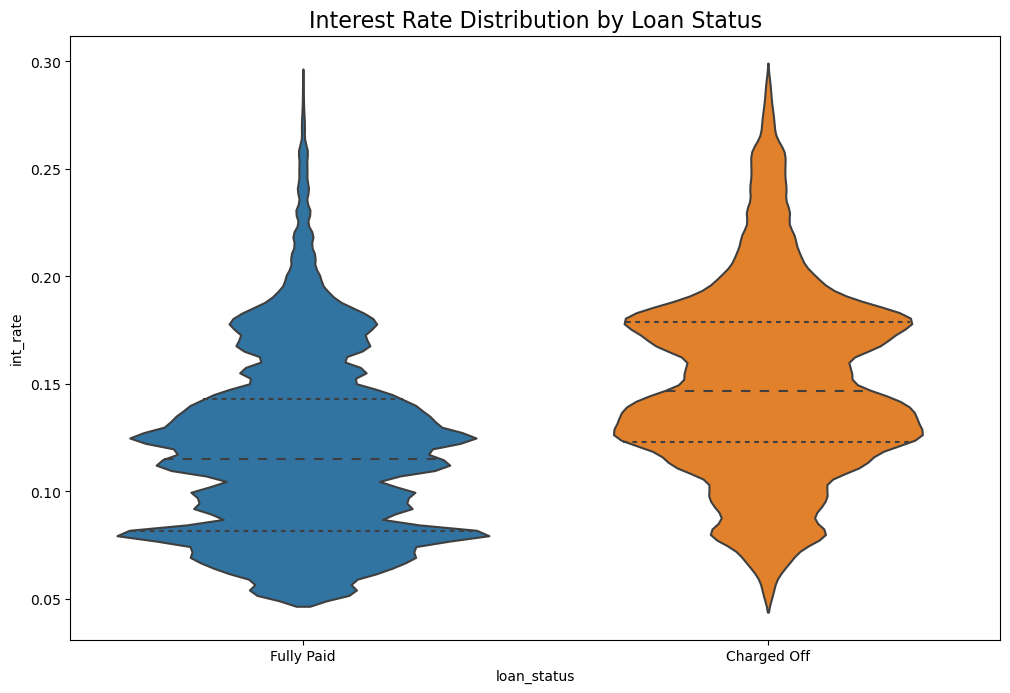

In [16]:
plot = violin_plot('loan_status', 'int_rate', data, 'Interest Rate Distribution by Loan Status')

print(plot) 


Interest rate appears to be a major factor because the charge off group's median interest rate is higher than the 75th percentile of the paid off group's interest rate. I.e a little more than 75% of the fully paid group paid a lower interest rate than the charged off group. Given how close the two groups are in most measures, it's possible that a qualitiative factor driving defaults were customers getting discouraged because they paid down their loans slower. 

Let's repeat the above and see what the distrubution looks like for income vs. loan status 



In [ ]:
ax = sns.violinplot(x="loan_status", y="log_monthly_income", inner='quartile', data=data)
ax.set_title('Distribution of income by loan status', fontsize=16)

Log was used as the incomes were so wide spread that the distribution was too lopsided to be informative, using log we can see that while the average is slightly higher for the fully paid group the distributions are also very similar. Given that interest rate, income and debt to income ratio are some of the few areas where we see significant differences, let's dig into those further. The first thing we'll do is separate income into bins and see what the charge off rate is for various income ranges and then we'll do the same for interest rates. 

In [51]:
# create the data frames we'll use for both interest rate and income bins 


# select a smaller subset of data (fewer columns)
bin_df = data[['int_rate', 'loan_status', 'annual_inc', 
                'log_monthly_income', 'monthly_income', 'dti_dec', 'post_loan_dti']]


# pandas dummy variable function will hot encode the loan_status column + delete the original 
bin_df = pd.get_dummies(bin_df)


# update the column names 
bin_df.rename(columns={'loan_status_Charged Off':'default'}, inplace = True)
bin_df.rename(columns={'loan_status_Fully Paid':'paid'}, inplace = True)


In [ ]:
bin_min.head(10)

In [67]:
# Bin analysis for income 
# call the make_bin function to generate the bins 
# returned data frame shows average value for each bin 
# using $5,000 to define the bins

# slice the bin data frame so it only includes annual income 
# below $200k so as to get rid a lot of the income outliers 

bin_min = bin_df[(bin_df['annual_inc'] <= 200000)]


income_bins = make_bins(bin_min, 5000, 'annual_inc')

income_bins.head(50)




/Users/markhamlee/opt/anaconda3/envs/data_science/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,int_rate,annual_inc,log_monthly_income,monthly_income,dti_dec,post_loan_dti,default,paid
annual_inc_bin,,,,,,,,
"[3800.0, 8800.0)",0.164,7231.382,6.384,602.615,0.342,0.521,0.176,0.824
"[8800.0, 13800.0)",0.154,11638.541,6.872,969.878,0.221,0.360,0.166,0.834
"[13800.0, 18800.0)",0.144,16502.916,7.223,1375.243,0.211,0.338,0.163,0.837
"[18800.0, 23800.0)",0.140,21263.220,7.478,1771.935,0.216,0.334,0.207,0.793
"[23800.0, 28800.0)",0.138,26041.209,7.681,2170.101,0.221,0.332,0.216,0.784
"[28800.0, 33800.0)",0.136,31019.620,7.857,2584.968,0.216,0.318,0.226,0.774
"[33800.0, 38800.0)",0.134,35997.010,8.006,2999.751,0.214,0.311,0.223,0.777
"[38800.0, 43800.0)",0.132,40929.690,8.134,3410.808,0.210,0.303,0.219,0.781
"[43800.0, 48800.0)",0.131,45987.858,8.251,3832.321,0.208,0.298,0.214,0.786


In [53]:
# call the make bin function to bins for interest rate
# set the the frequency as 0.0025 to set the bins at 0.25% apart 
# this function also groups the data by bins and shows the average value for
# each bin. 

interest_bins = make_bins(bin_df, 0.0025, 'int_rate')

interest_bins.dropna(inplace=True)

interest_bins.head(15)

,int_rate,annual_inc,log_monthly_income,monthly_income,dti_dec,post_loan_dti,default,paid
int_rate_bin,,,,,,,,
"[0.0532, 0.0557)",0.053,102500.285,8.922,8541.690,0.148,0.208,0.027,0.973
"[0.058199999999999995, 0.0607)",0.060,98422.615,8.882,8201.885,0.150,0.212,0.025,0.975
"[0.0607, 0.06319999999999999)",0.062,93228.791,8.814,7769.066,0.160,0.225,0.039,0.961
"[0.06319999999999999, 0.0657)",0.064,90638.825,8.808,7553.235,0.158,0.224,0.035,0.965
"[0.0657, 0.0682)",0.067,89473.478,8.774,7456.123,0.162,0.229,0.054,0.946
"[0.0682, 0.0707)",0.069,93451.457,8.790,7787.621,0.164,0.232,0.052,0.948
"[0.0707, 0.0732)",0.073,92356.980,8.790,7696.415,0.167,0.236,0.060,0.940
"[0.0732, 0.07569999999999999)",0.075,90651.531,8.795,7554.294,0.160,0.227,0.047,0.953
"[0.07819999999999999, 0.0807)",0.079,89147.341,8.759,7428.945,0.170,0.239,0.075,0.925


Text(0.5, 1.0, 'Interest Rate vs. Default Rate')

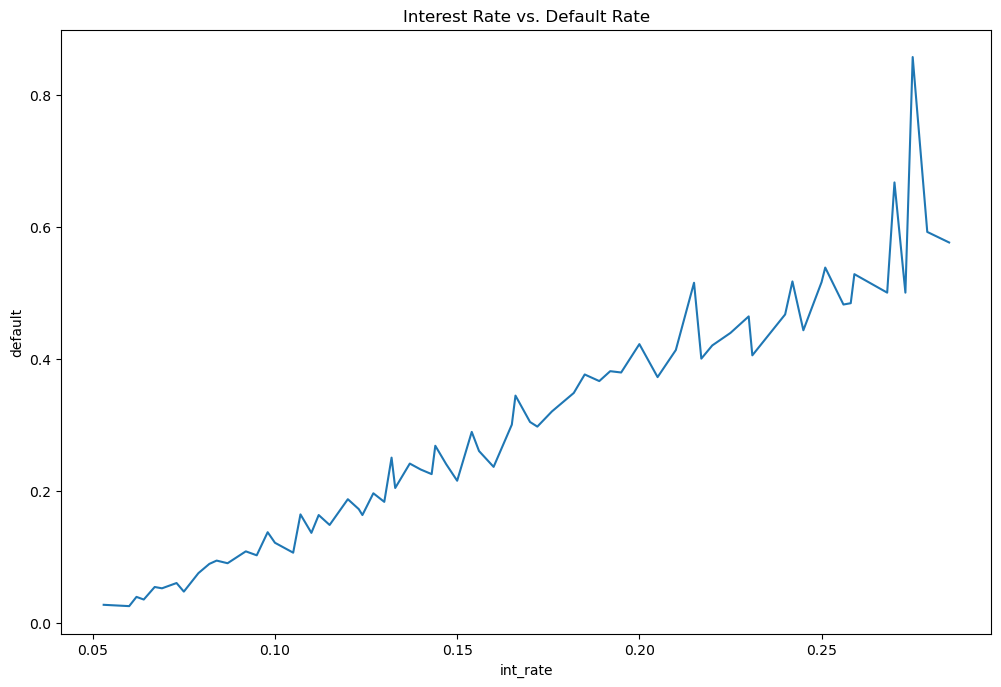

In [54]:
sns.lineplot(data=interest_bins, x='int_rate', y='default')
plt.title('Interest Rate vs. Default Rate')


Text(0.5, 1.0, 'Income vs. Default Rate')

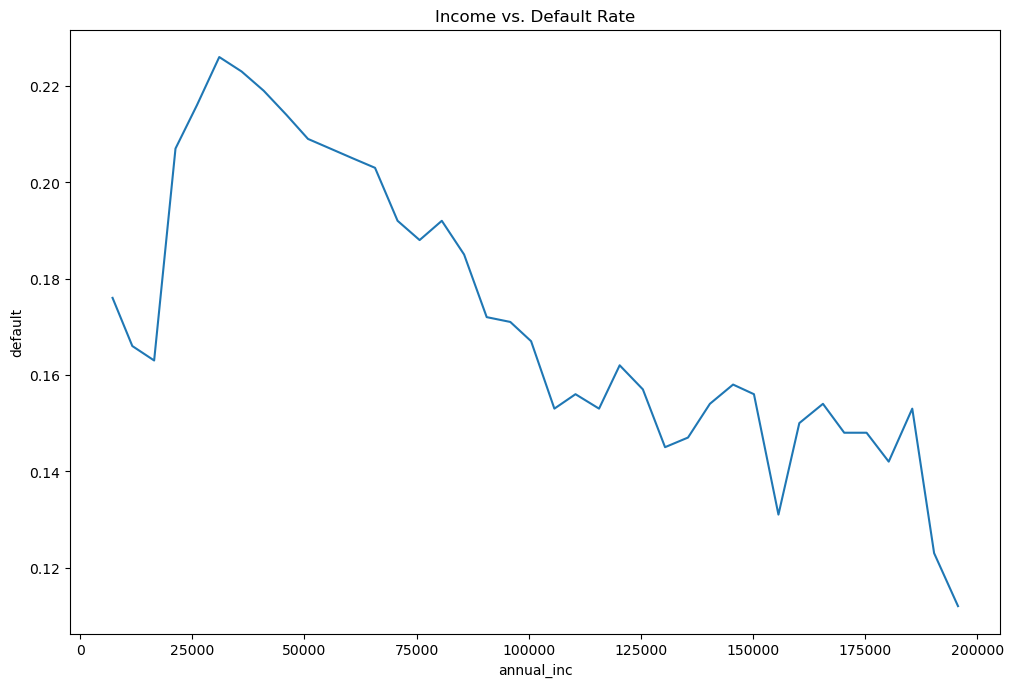

In [55]:





sns.lineplot(data=income_bins, x='annual_inc', y='default')
plt.title('Income vs. Default Rate')

Text(0.5, 1.0, 'Linear Model Plot - income vs. default rate')

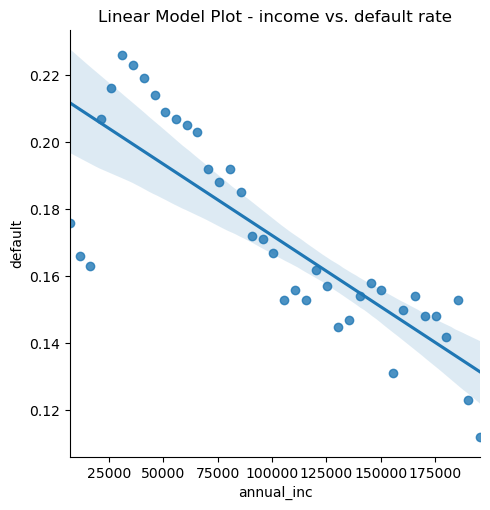

In [56]:
sns.lmplot(x="annual_inc", y="default", data=income_bins)
plt.title('Linear Model Plot - income vs. default rate')

Text(0.5, 1.0, 'Linear Model Plot - interest rate vs. default rate')

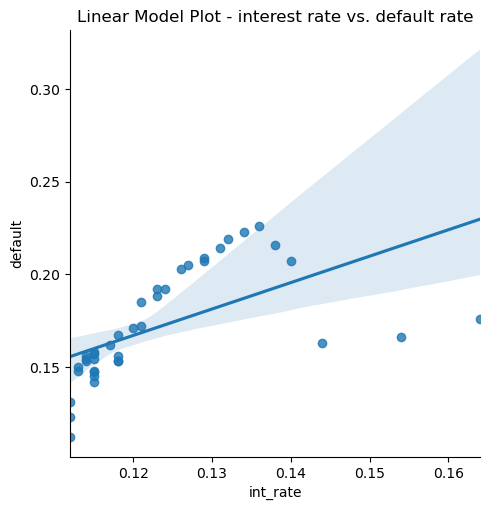

In [57]:
sns.lmplot(x="int_rate", y="default", data=income_bins)
plt.title('Linear Model Plot - interest rate vs. default rate')

The above plots and models could be useful for making lift calculations, in terms of estimating the likely default rate for a given cohort and then comparing the output to the performance of a machine learning model. However, the relationships are very generaal and overall, the data has mostly been useful for identifying probabilities as opposed to a strong indicator of whether or not someone is going to default on their loan. 